**Importing Libraries**

In this project, the libraries used are pandas, numpy, matplotlib, keras, and scikit learn. Pandas was mainly used for creating data frames, importing the dataset, and manipulating the dataset. Numpy was used for array manipulation (mainly changing dimennsions to fit the specifications of certain methods). The matplotlib library is used for data visualization. Keras is used to build the deep learning models, save their results, and export them. Scikit learn was mainly used to calculate the accuracy metrics of the models.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, LSTM
from keras import optimizers 
from keras import callbacks
from keras.models import model_from_json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
warnings.filterwarnings("ignore")

**Importing Data**

The "close" value of the original dataset was shifted by one position down, since sliding window is going to be used, and the prediction is going to be to the "following" closing hour given all other porperties of the current hour. After shifitng, the raw is renamed as "Close". The last raw is dropped, since no prediction can occur on that using the sliding window. The "date" column type is an object, so it had to be parsed into a date type and set as an index column (Determines the time-step of the sequence).

In [ ]:
df=pd.read_csv('Final_DataSet_20k.csv', index_col='date', parse_dates=['date'])


df['Close']=df['close'].shift(-1,fill_value=0)
df.drop(df.tail(1).index,inplace=True)
df = df.drop(columns=['close'])

df

,open,high,low,Volume BTC,Volume USDT,Close
date,,,,,,
2017-08-17 04:00:00,16199.91,16199.91,4261.32,44.5100,190952.85,4315.32
2017-08-17 05:00:00,4308.83,4328.69,4291.37,23.2300,100304.82,4324.35
2017-08-17 06:00:00,4315.32,4345.45,4309.37,7.2300,31282.31,4349.99
2017-08-17 07:00:00,4324.35,4349.99,4287.41,4.4400,19241.06,4360.69
2017-08-17 08:00:00,4349.99,4377.85,4333.32,0.9499,4139.70,4444.00
...,...,...,...,...,...,...
2019-11-28 11:00:00,7478.58,7490.89,7446.03,1934.3100,14448429.61,7444.12
2019-11-28 12:00:00,7479.54,7479.77,7418.00,2274.0700,16927986.78,7455.67
2019-11-28 13:00:00,7444.12,7468.00,7437.21,1585.7500,11821588.19,7459.51


**Data Partitioning**

The dataset is partitioned into 70% training, 20% validation, and 10% testing.

In [ ]:
train_size = int(len(df)*0.7)
validation_size= int(len(df)*0.9)
train_dataset,validation_dataset,test_dataset = df.iloc[:train_size],df.iloc[train_size:validation_size],df.iloc[validation_size:]

**Plotting Data**

Plotting all data and dividing it into training, validation, and testing on the plot. Also, the size of each dataset is outputted.

Volume of all data:  20000
Volume of train data:  14000
Volume of validation data: 4000
Volume of test data:  2000


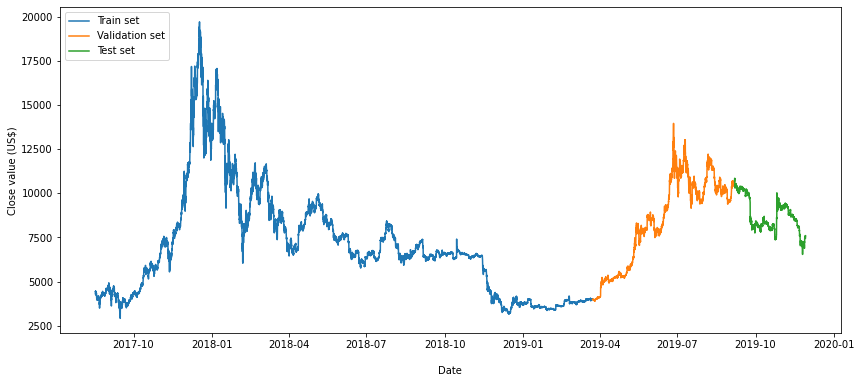

In [ ]:
plt.figure(figsize = (14, 6))
plt.rcParams['figure.dpi'] = 360
plt.plot(train_dataset.Close)
plt.plot(validation_dataset.Close)
plt.plot(test_dataset.Close)
plt.xlabel('\nDate')
plt.ylabel('Close value (US$)')
plt.legend(['Train set', 'Validation set', 'Test set'], loc='upper left')
print('Volume of all data: ',len(df))
print('Volume of train data: ', len(train_dataset))
print('Volume of validation data:', len(validation_dataset))
print('Volume of test data: ', len(test_dataset))

**Data Normalization and Splitting**

The MinMaxScaler was used to normalize the data between 0 and 1.  Before normalizing each dataset (training, validation, and testing), datasets were split into X and Y. The X datasets contain all features except of the "Close" feature (the feature to be predicted). This separation of features led us to the usage of two different scalers, one for X datasets (input) and one for  Y datasets (output). This was a crucial step, since it allowed for a correct reversing of normalization. After each X and Y for each of the 3 datasets is normalized, the results are stored in new values.

In [ ]:
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

x_train=train_dataset.drop('Close', axis=1)
y_train=train_dataset.loc[:,['Close']]

x_validation=validation_dataset.drop('Close', axis=1)
y_validation=validation_dataset.loc[:,['Close']]

x_test=test_dataset.drop('Close', axis=1)
y_test=test_dataset.loc[:,['Close']]

input_scaler = scaler_x.fit(x_train)
output_scaler = scaler_y.fit(y_train)

train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(x_train)

validation_y_norm = output_scaler.transform(y_validation)
validation_x_norm = input_scaler.transform(x_validation)

test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(x_test)

test_inverse = scaler_y.inverse_transform(test_y_norm)

**Creating a 3-D Dimensional Dataset Using Sliding Window**

Each of the X and Y datasets created above need to be transformed into 3-D datasets since GRU and LSTM only accept datasets with a 3-D dimension. The 3-D dimension represents (batch, timestep, feature). Moreover, this code determines the lookback period of the models (referred to as "lag"). The loockback period used for the 20k dataset is 12 hours. After executing the sliding window, the y_test dataset is set back into a 1D dataset and the normalization is reversed since it will be used in the actual prediction. 1D becuase the prediction values will also be 1D. Both need to be of the same dimension in order to visualize them using matplotlib.

In [ ]:
def sliding_window (data, close_data, lag=1 ):

  data_array= []
  close_data_array= []

  for i in range (len(data)-lag):
     time_step= data [i:i+lag:]
     data_array.append(time_step)
     close_data_array.append(close_data[i+lag:i+lag+1])

  return np.array(data_array), np.array(close_data_array)

LAG=2



x_train , y_train=  sliding_window(train_x_norm, train_y_norm, LAG)
x_validation, y_validation= sliding_window(validation_x_norm, validation_y_norm, LAG)
x_test, y_test= sliding_window(test_x_norm, test_y_norm, LAG)

print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)
print('x_validation.shape: ', x_validation.shape)
print('y_validation.shape: ', y_validation.shape)
print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

test_1D= y_test [:, 0, 0]

M=[]

for i in range (len(test_1D)):

  D=[]
  D.append(test_1D[i])
  M.append(D)



y_test=scaler_y.inverse_transform(M)

x_train.shape:  (13998, 2, 5)
y_train.shape:  (13998, 1, 1)
x_validation.shape:  (3998, 2, 5)
y_validation.shape:  (3998, 1, 1)
x_test.shape:  (1998, 2, 5)
y_test.shape:  (1998, 1, 1)


**THE GRU Model**

The GRU Model consists of 3 layers. An input layer and one deep layer that each consist of 72 nodes, and an output layer that consists of a single node representing the single feature predicted which is "Close" price. Dropout was added to the deep layers to optimize their performance. The other parameters were tunned to 0.0001 learning rate, an epoch size of 600, and a batach size of 256 (13998/256 = 55 batches). The model is compiled using the MSE as a loss function and Adam optimizer. Early stopping is used with a patience of 550. I noticed that I need to be patient with the model, give it time, and it will give me the needed results. There is still room to possibly manipulate the batch size when changing the window size for further experimentation on the affect of that on the perofrmance.

In [ ]:
learning_rate_GRU=0.0001
neurons_GRU=72
batch_size_GRU=256
epoch_GRU=600

GRU_model=Sequential()

GRU_model.add(GRU(units=neurons_GRU, return_sequences=True, input_shape=[x_train.shape[1], x_train.shape[2]],
                  activation = 'sigmoid'))
GRU_model.add(Dropout(0.2))

GRU_model.add(GRU(units=neurons_GRU, return_sequences=True, activation = 'sigmoid'))
GRU_model.add(Dropout(0.2))

GRU_model.add(Dense(units=1))


GRU_model.compile(loss="mean_squared_error", optimizer="adam")
early_stop_GRU = callbacks.EarlyStopping(monitor = 'val_loss', patience = 550)
history_GRU = GRU_model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=epoch_GRU, batch_size=batch_size_GRU, shuffle=False, callbacks=[early_stop_GRU])

Epoch 1/600
55/55 [==============================] - 6s 23ms/step - loss: 0.1253 - val_loss: 0.1188
Epoch 2/600
55/55 [==============================] - 1s 17ms/step - loss: 0.0787 - val_loss: 0.0942
Epoch 3/600
55/55 [==============================] - 1s 17ms/step - loss: 0.0703 - val_loss: 0.0991
Epoch 4/600
55/55 [==============================] - 1s 17ms/step - loss: 0.0650 - val_loss: 0.1030
Epoch 5/600
55/55 [==============================] - 1s 18ms/step - loss: 0.0610 - val_loss: 0.1107
Epoch 6/600
55/55 [==============================] - 1s 17ms/step - loss: 0.0595 - val_loss: 0.1112
Epoch 7/600
55/55 [==============================] - 1s 17ms/step - loss: 0.0594 - val_loss: 0.1065
Epoch 8/600
55/55 [==============================] - 1s 18ms/step - loss: 0.0593 - val_loss: 0.0961
Epoch 9/600
55/55 [==============================] - 1s 21ms/step - loss: 0.0591 - val_loss: 0.0813
Epoch 10/600
55/55 [==============================] - 1s 25ms/step - loss: 0.0588 - val_loss: 0.0667

**GRU-Exporting the Model**

In case the model perofrmed really well, the model itself is exported into a JSON file and the weights of the model are exported in a h5 file.

In [ ]:
loss_training_GRU=history_GRU.history['loss'][-1]
loss_validation_GRU=history_GRU.history['loss'][-1]
GRU_model_json=GRU_model.to_json()
with open("GRU_model_20k_epoch600.json", "w") as json_file:
  json_file.write(GRU_model_json)

GRU_model.save_weights("GRU_model_20k_epoch600.h5")
print("saved the GRU model to disk")

saved the GRU model to disk


**GRU-Visualizing The Trian Loss and The Validation Loss**

prints out a table that shows the "before the last" loss of training and validation while training the model. It also shows the learning rate used.

In [ ]:
learning_rate_index_GRU=learning_rate_GRU
training_loss_GRU=history_GRU.history['loss'][-1]
validation_loss_GRU=history_GRU.history['val_loss'][-1]
learning_rate_index_GRU= pd.DataFrame(data=[[learning_rate_index_GRU, training_loss_GRU, validation_loss_GRU]], columns = ['Learning Rate',
                                                                                                           'Training Loss', 'Validation Loss'])
learning_rate_index_GRU

,Learning Rate,Training Loss,Validation Loss
0,0.0001,0.000509,0.000428


**GRU-Plotting Validation Loss and Training Loss**

The validation loss keeps going up and down. This is not a sign of overfitting. The variations were much severe when a higher learning rate was used. This could have been avoided by assigning a small epoch, however the training loss would still be high and prediction accuracy would have been low.

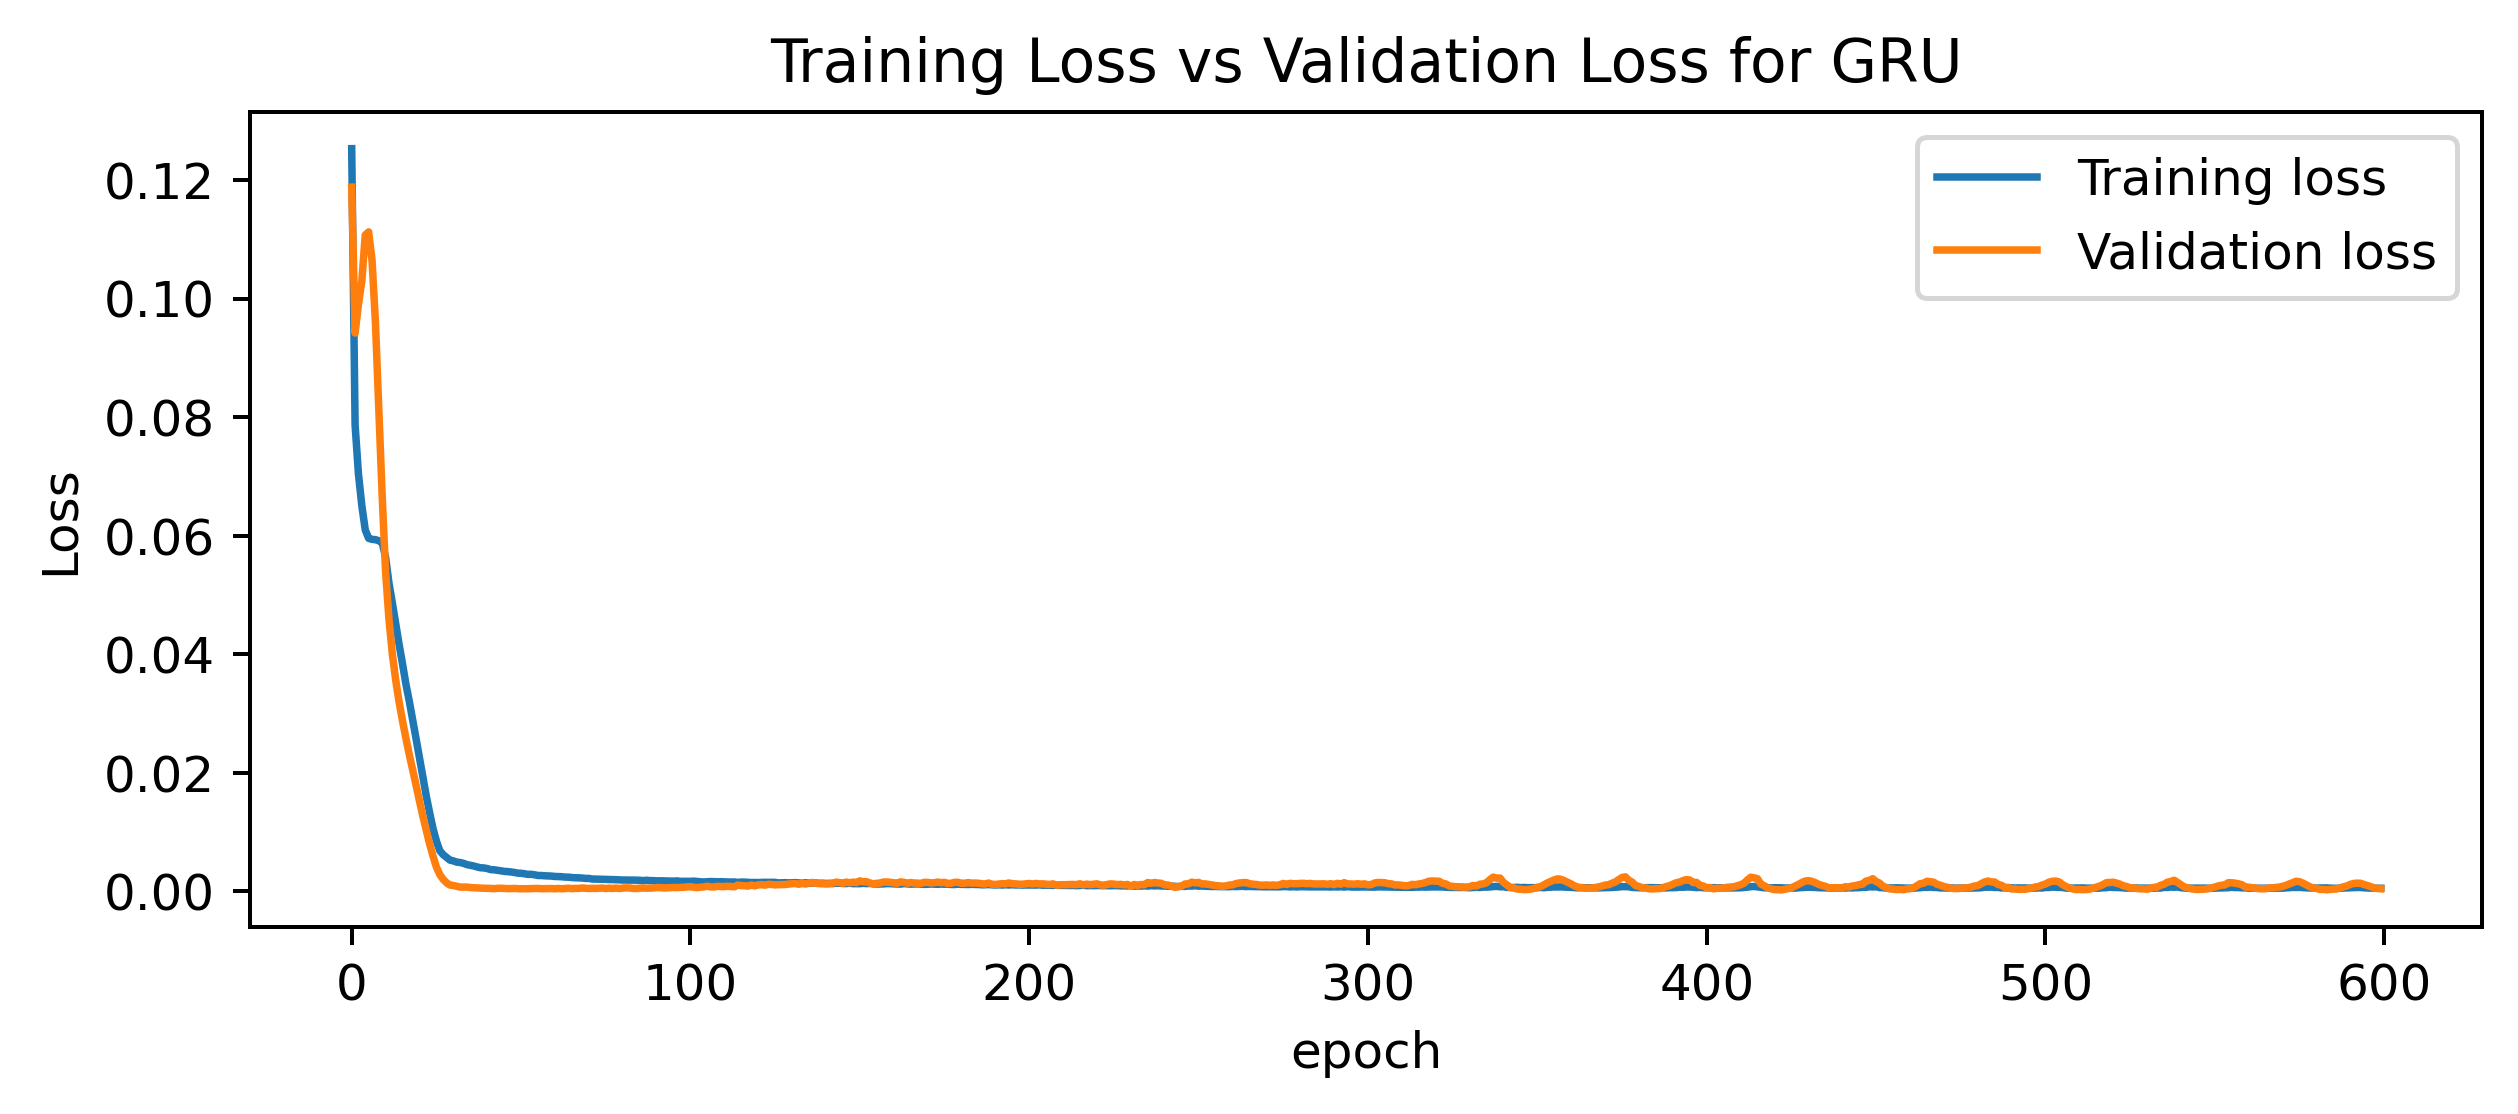

In [ ]:
plt.figure(figsize = (8, 3))
plt.rcParams['figure.dpi'] = 360
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])
plt.title('Training Loss vs Validation Loss for GRU')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

**GRU-Prediction**

Evaluating the performance of the model by predicting the "Close" value using the testing dataset (X dataset). After that, the results are stored and transformed into a 1D dataset to visualize them by plotting. Also, the normalized values are reversed back to the original non-normalized values for better visualization and evaluation of the perofrmance of the model.

In [ ]:
prediction_GRU = GRU_model.predict(x_test)

prediction_1D_GRU = prediction_GRU [:, 0, 0]

C_GRU=[]

for i in range (len(prediction_1D_GRU)):

  D=[]
  D.append(prediction_1D_GRU[i])
  C_GRU.append(D)



prediction_GRU=scaler_y.inverse_transform(C_GRU)

**GRU-Visualizing The Prediction Results**

The predicted values and the actual values are put in a table in order to help better compare the differences between the actual and predicted values.

In [ ]:
dataCompare_GRU = pd.DataFrame()
dataTest_GRU= np.array(df['Close'][validation_size+LAG:])
dataPredict_GRU= np.array(prediction_GRU)

dataCompare_GRU['Testing Data']=dataTest_GRU
dataCompare_GRU['Predicted Data']=dataPredict_GRU

dataCompare_GRU

,Testing Data,Predicted Data
0,10834.87,10505.707312
1,10821.00,10548.496165
2,10788.86,10532.704671
3,10820.99,10369.498549
4,10843.00,10580.202250
...,...,...
1993,7444.12,7388.296936
1994,7455.67,7376.394019
1995,7459.51,7382.620946
1996,7609.28,7358.490355


**GRU-Plotting The Actual Values and The Predicted Values**

As observed, the predicted values are very accurate in predicting the movement of the price (up and down), however they are slightly higher than the actual values. This is because of the reguralization used in the training set (dropout) and not in the other sets (in order to better generalize). Moreover, it is slightly visible that the pattern of the predicted values are shifted a little bit to the left. This  shift is actually due to usage of sliding window.

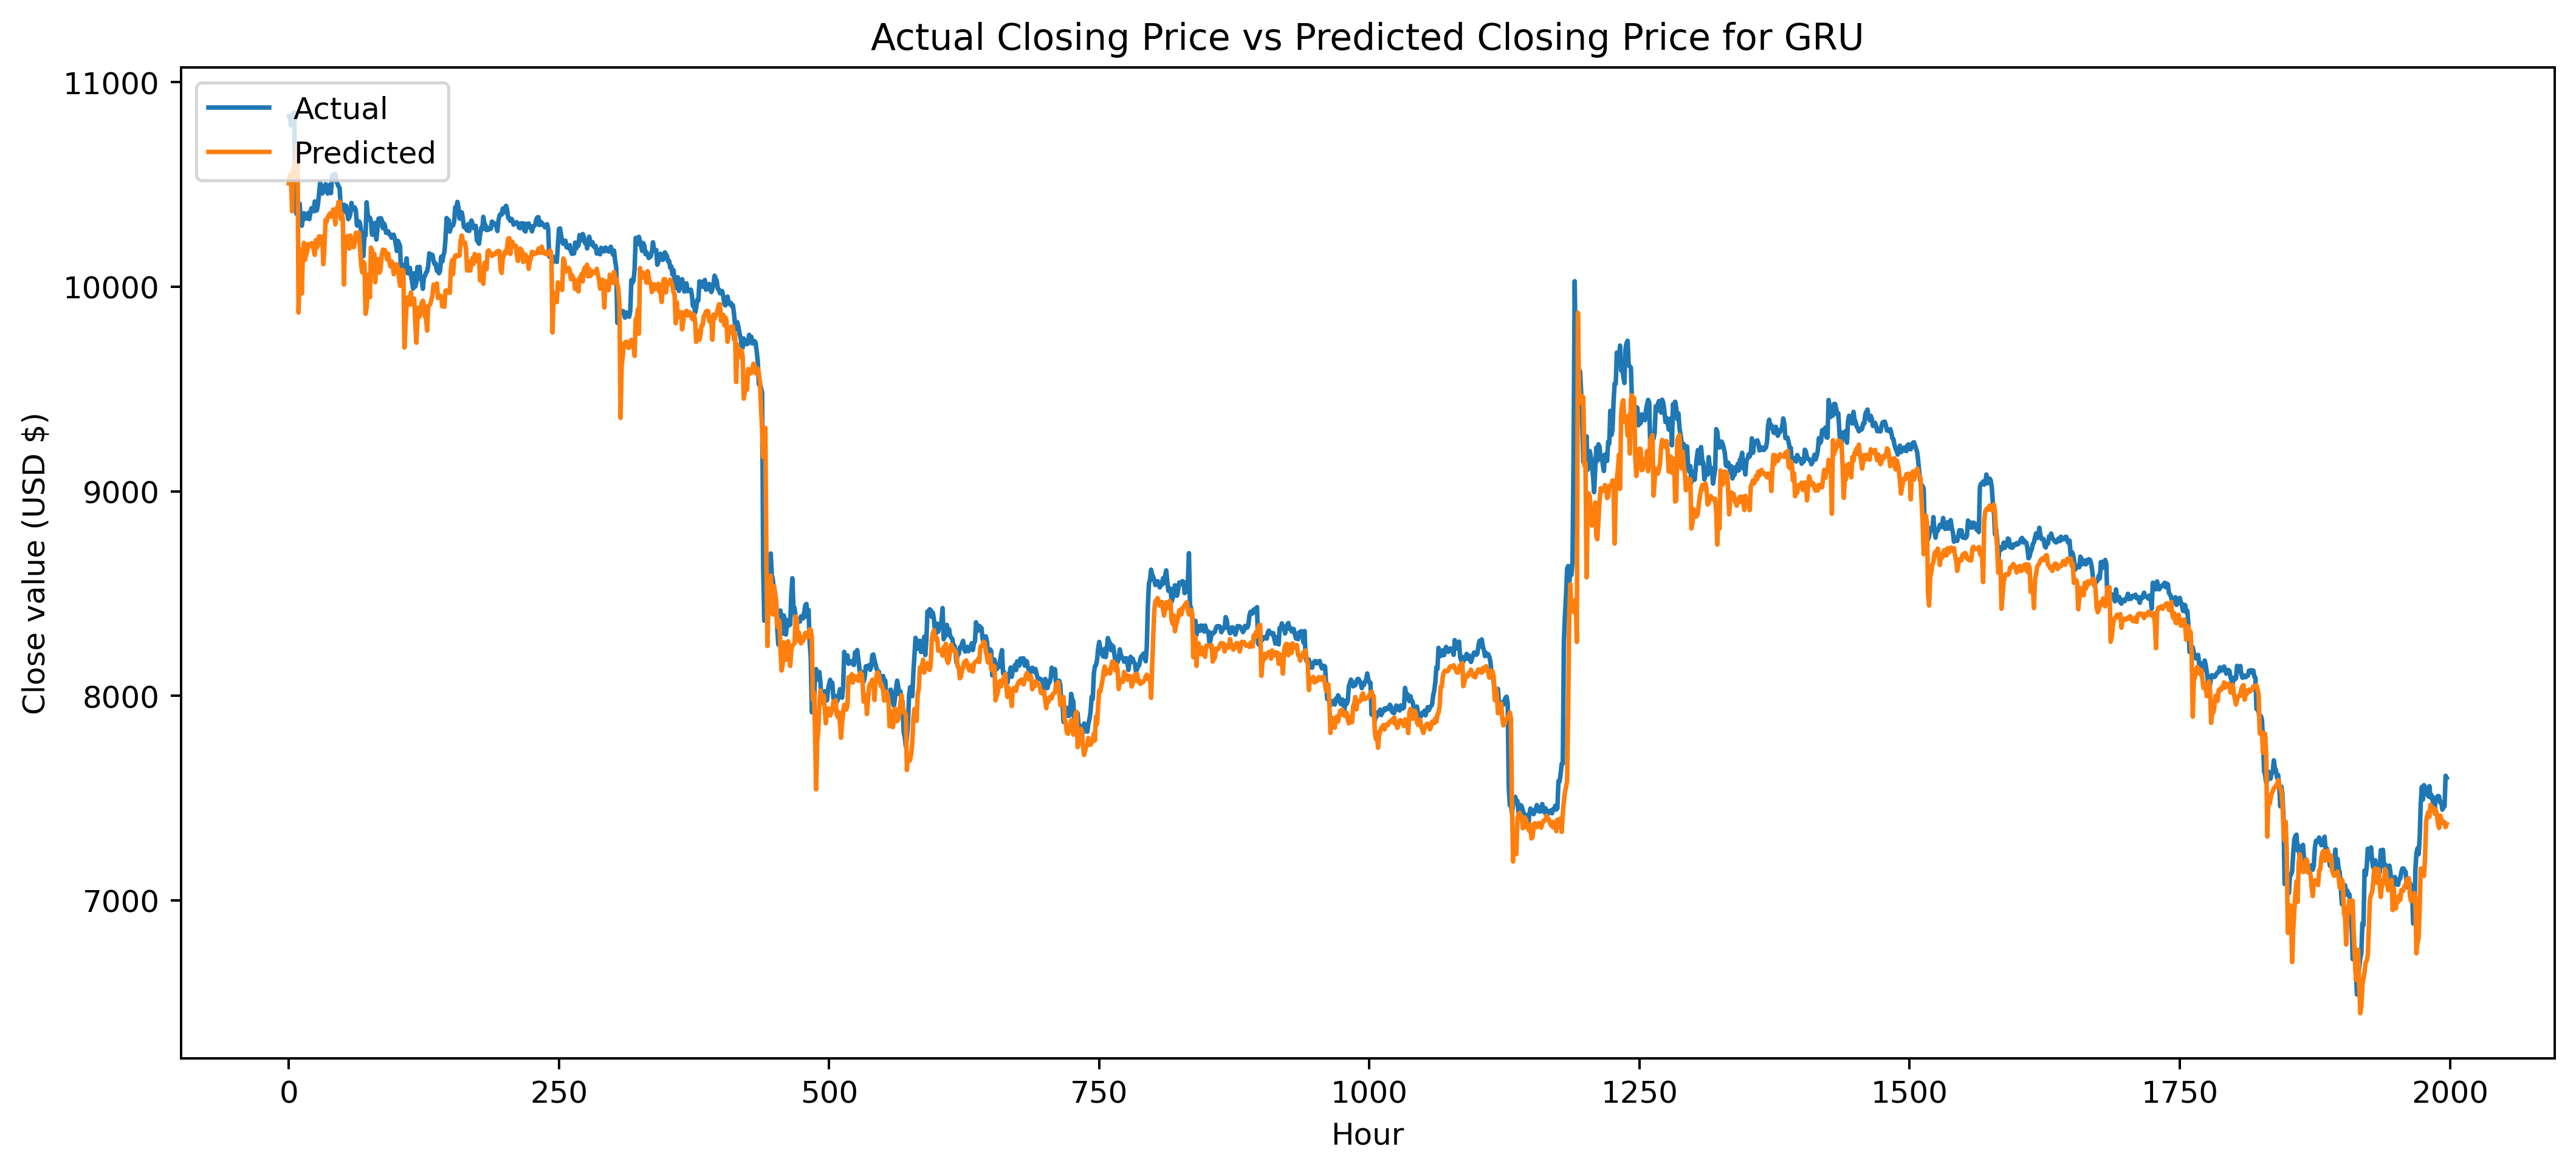

In [ ]:
plt.figure(figsize=(14, 6))
plt.rcParams['figure.dpi'] = 360
range_future_GRU = len(prediction_GRU)
plt.plot(np.arange(range_future_GRU), np.array(y_test), label='Actual')
plt.plot(np.arange(range_future_GRU), np.array(prediction_GRU),label='Predicted')

plt.title('Actual Closing Price vs Predicted Closing Price for GRU')
plt.legend(loc='upper left')
plt.xlabel('Hour')
plt.ylabel('Close value (USD $)')

plt.show()

**GRU-Percent Accuracy**

This accuracy metrics is not used in evaluating regression models. It is just used here to get a sense of performance, but it will not be reported.

In [ ]:
percent_tot_GRU=0
for i in range (len(y_test)):
  a=y_test[0]
  result_a=a[0]
  b=prediction_GRU[0]
  result_b=b[0]

  percent= ((result_b*100)/result_a)
  if percent >100:
    percent = 100 - (percent - 100)
  percent_tot_GRU+=percent

percent_tot_GRU= percent_tot_GRU/len(y_test)

print('GRU Accuracy %: ', percent_tot_GRU)

GRU Accuracy %:  96.96200611560683


**GRU-Regression Accuracy Metrics**

In order to measure the performance of the model when exposed to new data, MAE, MSE, RMSE, and MAPE are calculated for the normalized values of the predicted values and the actual values.

In [ ]:
mae_norm_GRU = mean_absolute_error(M, C_GRU)

mse_norm_GRU = mean_squared_error(M, C_GRU)

rmse_norm_GRU = mean_squared_error(M, C_GRU, squared=False)

mape_norm_GRU =mean_absolute_percentage_error(M, C_GRU)

print('GRU MAE-Normalized: ', mae_norm_GRU)
print ('GRU MSE-Normalized: ', mse_norm_GRU)
print('GRU RMSE-Normalized: ', rmse_norm_GRU)
print('GRU MAPE-Normalized: ', mape_norm_GRU)

GRU MAE-Normalized:  0.008304764163070997
GRU MSE-Normalized:  0.00011425333617044994
GRU RMSE-Normalized:  0.010688935221548025
GRU MAPE-Normalized:  0.023736743052617224


**GRU-Regression Accuracy Metrics Unlocked**

In the following code, MSE, RMSE, and MAE are calculated using the numpy library and using values that are not normalized. This helps in making sense of the results.

In [ ]:
errors_GRU = prediction_GRU - y_test
mse_GRU = np.square(errors_GRU).mean()
rmse_GRU = np.sqrt(mse_GRU)
mae_GRU = np.abs(errors_GRU).mean()


print('GRU MAE: {:.4f}'.format(mae_GRU))
print('GRU MSE: {:.4f}'.format(mse_GRU))
print('GRU RMSE: {:.4f}'.format(rmse_GRU))

GRU MAE: 139.4411
GRU MSE: 32210.4022
GRU RMSE: 179.4726


**GRU-Model Imported**

This allows us to export a model that is already saved in a JSON file and its corresnponding weights in a h5 file. The model is restored and can be used to make predictionsn visualize results, and do some data manipulation.

In [ ]:
json_file_GRU = open ('GRU_model_20k_epoch600.json', 'r')
loaded_model_json_GRU = json_file_GRU.read()
json_file_GRU.close()
loaded_model_GRU = model_from_json(loaded_model_json_GRU)

loaded_model_GRU.load_weights("GRU_model_20k_epoch600.h5")
print("loaded GRU model from disk")

prediction_again_GRU=loaded_model_GRU.predict(x_test)

prediction_1D_again_GRU= prediction_again_GRU [:, 0, 0]

C_again_GRU=[]

for i in range (len(prediction_1D_again_GRU)):

  D=[]
  D.append(prediction_1D_again_GRU[i])
  C_again_GRU.append(D)



prediction_again_GRU=scaler_y.inverse_transform(C_again_GRU)


prediction_again_GRU

loaded GRU model from disk


array([[10505.70731202],
       [10548.49616492],
       [10532.70467129],
       ...,
       [ 7382.6209458 ],
       [ 7358.4903546 ],
       [ 7373.26003981]])

**The LSTM Model**

The LSTM has the same architecture and parameters as the GRU model.

In [ ]:
learning_rate_LSTM=0.0001
neurons_LSTM=72
batch_size_LSTM=256
epoch_LSTM=600

LSTM_model=Sequential()

LSTM_model.add(LSTM(units=neurons_LSTM, return_sequences=True, input_shape=[x_train.shape[1], x_train.shape[2]],
                  activation = 'sigmoid'))
LSTM_model.add(Dropout(0.2))

LSTM_model.add(LSTM(units=neurons_LSTM, return_sequences=True, activation = 'sigmoid'))
LSTM_model.add(Dropout(0.2))

LSTM_model.add(Dense(units=1))


LSTM_model.compile(loss="mean_squared_error", optimizer="adam")
early_stop_LSTM = callbacks.EarlyStopping(monitor = 'val_loss', patience = 1150)
history_LSTM = LSTM_model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=epoch_LSTM, batch_size=batch_size_LSTM, shuffle=False, callbacks=[early_stop_LSTM])

Epoch 1/600
55/55 [==============================] - 3s 20ms/step - loss: 0.0771 - val_loss: 0.0968
Epoch 2/600
55/55 [==============================] - 1s 14ms/step - loss: 0.0789 - val_loss: 0.0980
Epoch 3/600
55/55 [==============================] - 1s 14ms/step - loss: 0.0689 - val_loss: 0.1103
Epoch 4/600
55/55 [==============================] - 1s 14ms/step - loss: 0.0677 - val_loss: 0.1213
Epoch 5/600
55/55 [==============================] - 1s 14ms/step - loss: 0.0687 - val_loss: 0.1182
Epoch 6/600
55/55 [==============================] - 1s 15ms/step - loss: 0.0698 - val_loss: 0.1083
Epoch 7/600
55/55 [==============================] - 1s 14ms/step - loss: 0.0706 - val_loss: 0.0945
Epoch 8/600
55/55 [==============================] - 1s 16ms/step - loss: 0.0701 - val_loss: 0.0810
Epoch 9/600
55/55 [==============================] - 1s 15ms/step - loss: 0.0679 - val_loss: 0.0704
Epoch 10/600
55/55 [==============================] - 1s 14ms/step - loss: 0.0655 - val_loss: 0.0623

**LSTM-Exporting the Model**

In case the model perofrmed really well, the model itself is exported into a JSON file and the weights of the model are exported in a h5 file.

In [ ]:
loss_training_LSTM=history_LSTM.history['loss'][-1]
loss_validation_LSTM=history_LSTM.history['loss'][-1]
LSTM_model_json=LSTM_model.to_json()
with open("LSTM_model_20k_batch256.json", "w") as json_file:
  json_file.write(LSTM_model_json)

LSTM_model.save_weights("LSTM_model_20k_batch256.h5")
print("saved the LSTM model to disk")

saved the LSTM model to disk


**LSTM-Visualizing The Trian Loss and The Validation Loss**

prints out a table that shows the "before the last" loss of training and validation while training the model. It also shows the learning rate used.

In [ ]:
learning_rate_index_LSTM=learning_rate_LSTM
training_loss_LSTM=history_LSTM.history['loss'][-1]
validation_loss_LSTM=history_LSTM.history['val_loss'][-1]
learning_rate_index_LSTM= pd.DataFrame(data=[[learning_rate_index_LSTM, training_loss_LSTM, validation_loss_LSTM]], columns = ['Learning Rate',
                                                                                                           'Training Loss', 'Validation Loss'])
learning_rate_index_LSTM

,Learning Rate,Training Loss,Validation Loss
0,0.0001,0.000587,0.00079


**LSTM-Plotting Validation Loss and Training Loss**

The validation loss keeps going up and down. This is not a sign of overfitting. The variations were much severe when a higher learning rate was used. This could have been avoided by assigning a small epoch, however the training loss would still be high and prediction accuracy would have been low.

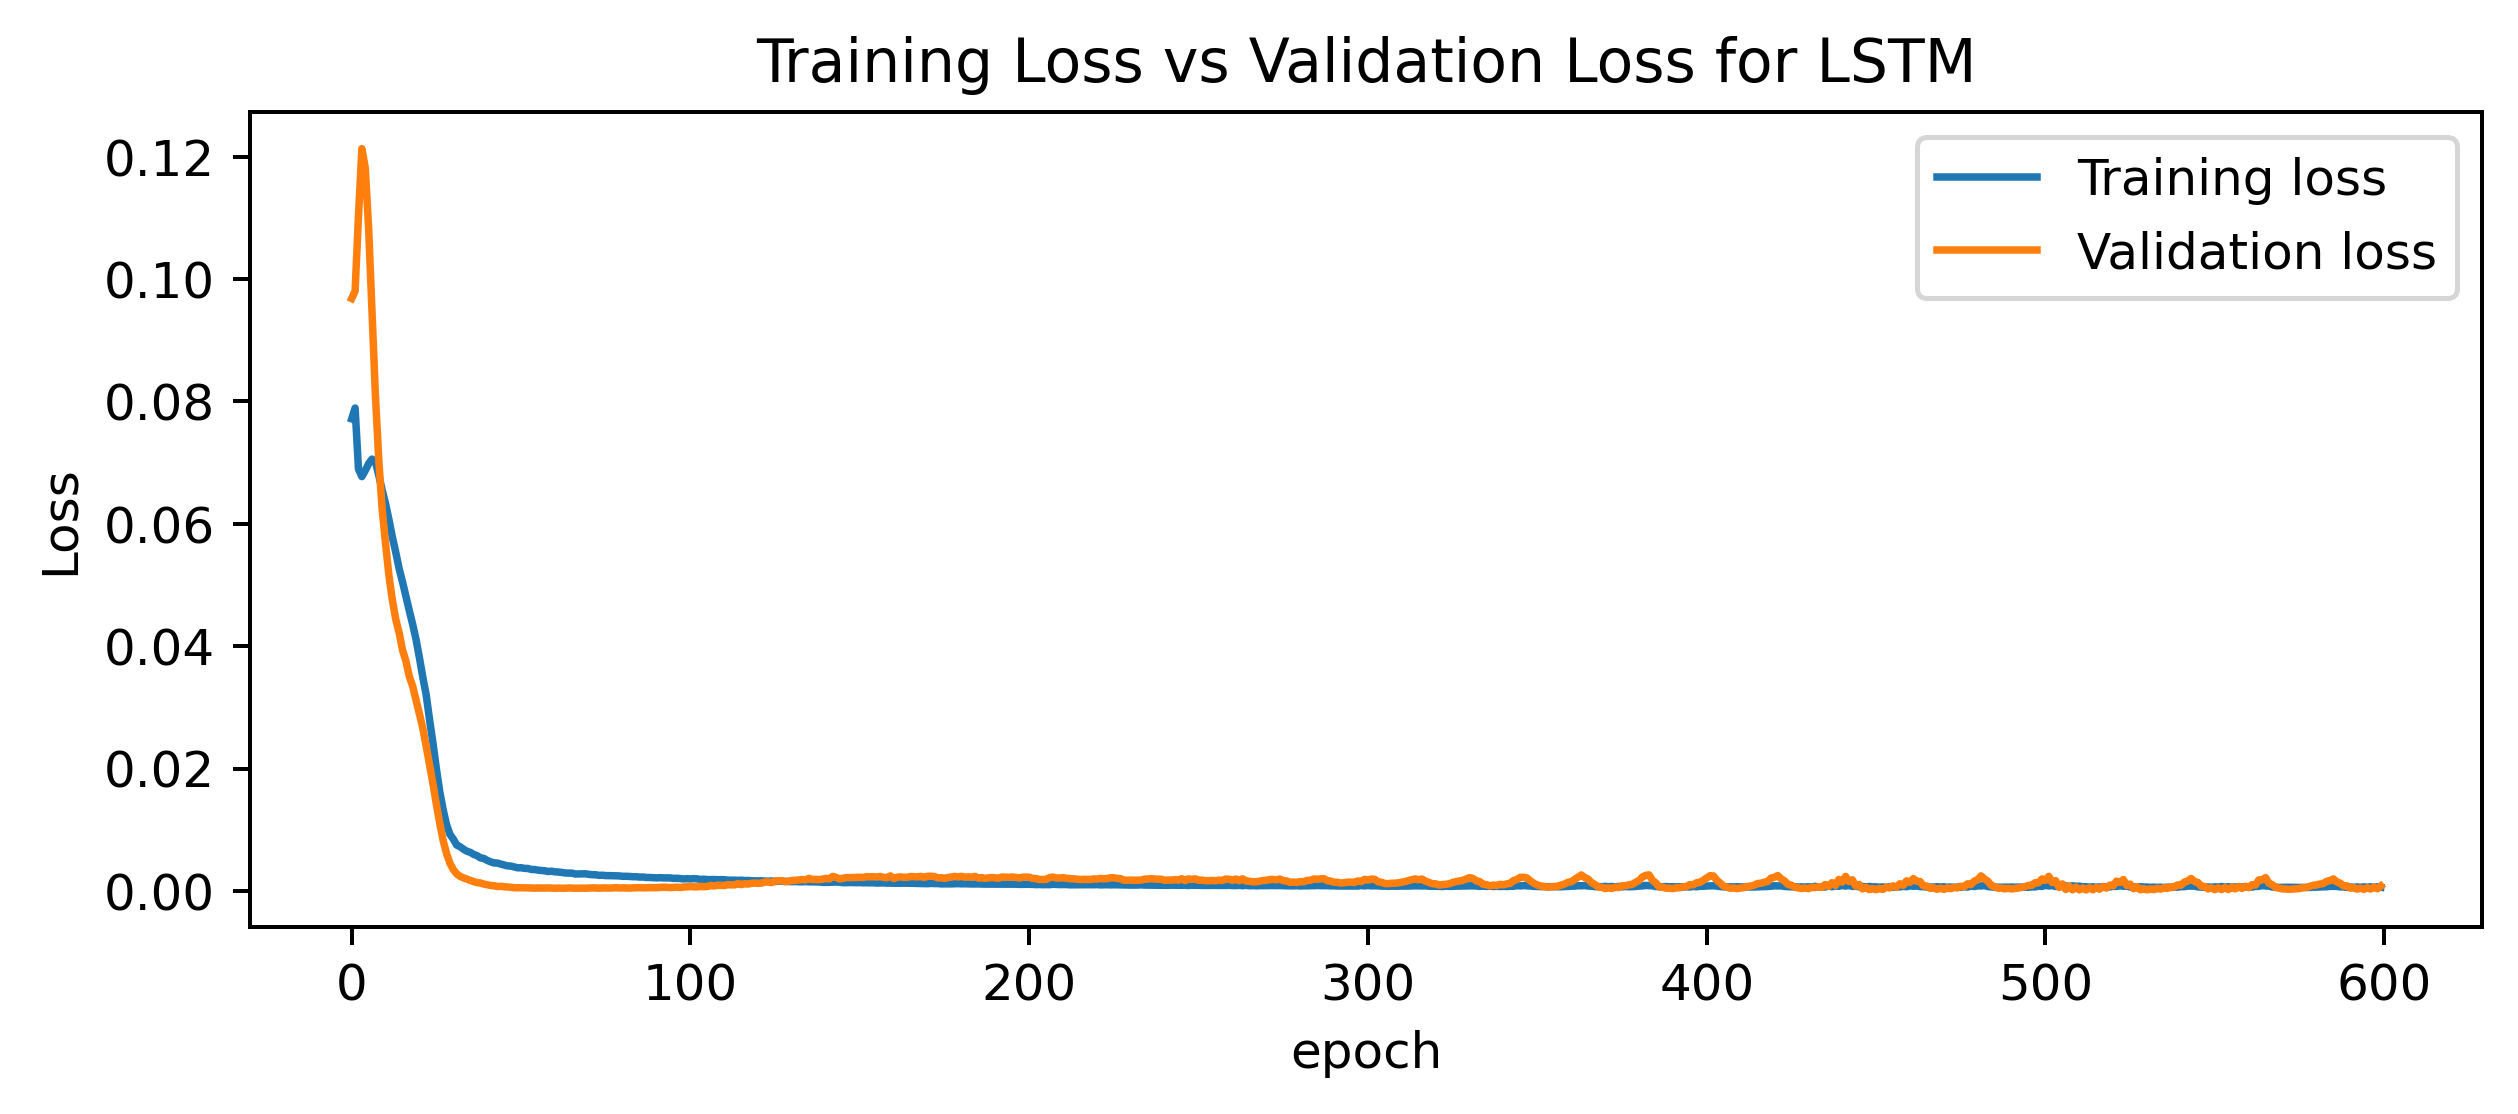

In [ ]:
plt.figure(figsize = (8, 3))
plt.rcParams['figure.dpi'] = 360
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('Training Loss vs Validation Loss for LSTM')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

**LSTM-Prediction**

Evaluating the performance of the model by predicting the "Close" value using the testing dataset (X dataset). After that, the results are stored and transformed into a 1D dataset to visualize them by plotting. Also, the normalized values are reversed back to the original non-normalized values for better visualization and evaluation of the perofrmance of the model.

In [ ]:
prediction_LSTM = LSTM_model.predict(x_test)

prediction_1D_LSTM = prediction_LSTM [:, 0, 0]

C_LSTM=[]

for i in range (len(prediction_1D_LSTM)):

  D=[]
  D.append(prediction_1D_LSTM[i])
  C_LSTM.append(D)



prediction_LSTM=scaler_y.inverse_transform(C_LSTM)

**LSTM-Visualizing The Prediction Results**

The predicted values and the actual values are put in a table in order to help better compare the differences between the actual and predicted values.

In [ ]:
dataCompare_LSTM = pd.DataFrame()
dataTest_LSTM= np.array(df['Close'][validation_size+LAG:])
dataPredict_LSTM= np.array(prediction_LSTM)

dataCompare_LSTM['Testing Data']=dataTest_LSTM
dataCompare_LSTM['Predicted Data']=dataPredict_LSTM

dataCompare_LSTM

,Testing Data,Predicted Data
0,10834.87,10567.638309
1,10821.00,10579.924530
2,10788.86,10586.440185
3,10820.99,10510.008715
4,10843.00,10664.635550
...,...,...
1993,7444.12,7442.389733
1994,7455.67,7429.036168
1995,7459.51,7427.012567
1996,7609.28,7408.563971


**LSTM-Plotting The Actual Values and The Predicted Values**

As observed, the predicted values are very accurate in predicting the movement of the price (up and down), however they are slightly higher than the actual values. This is because of the reguralization used in the training set (dropout) and not in the other sets (in order to better generalize). Moreover, it is slightly visible that the pattern of the predicted values are shifted a little bit to the left. This  shift is actually due to usage of sliding window.

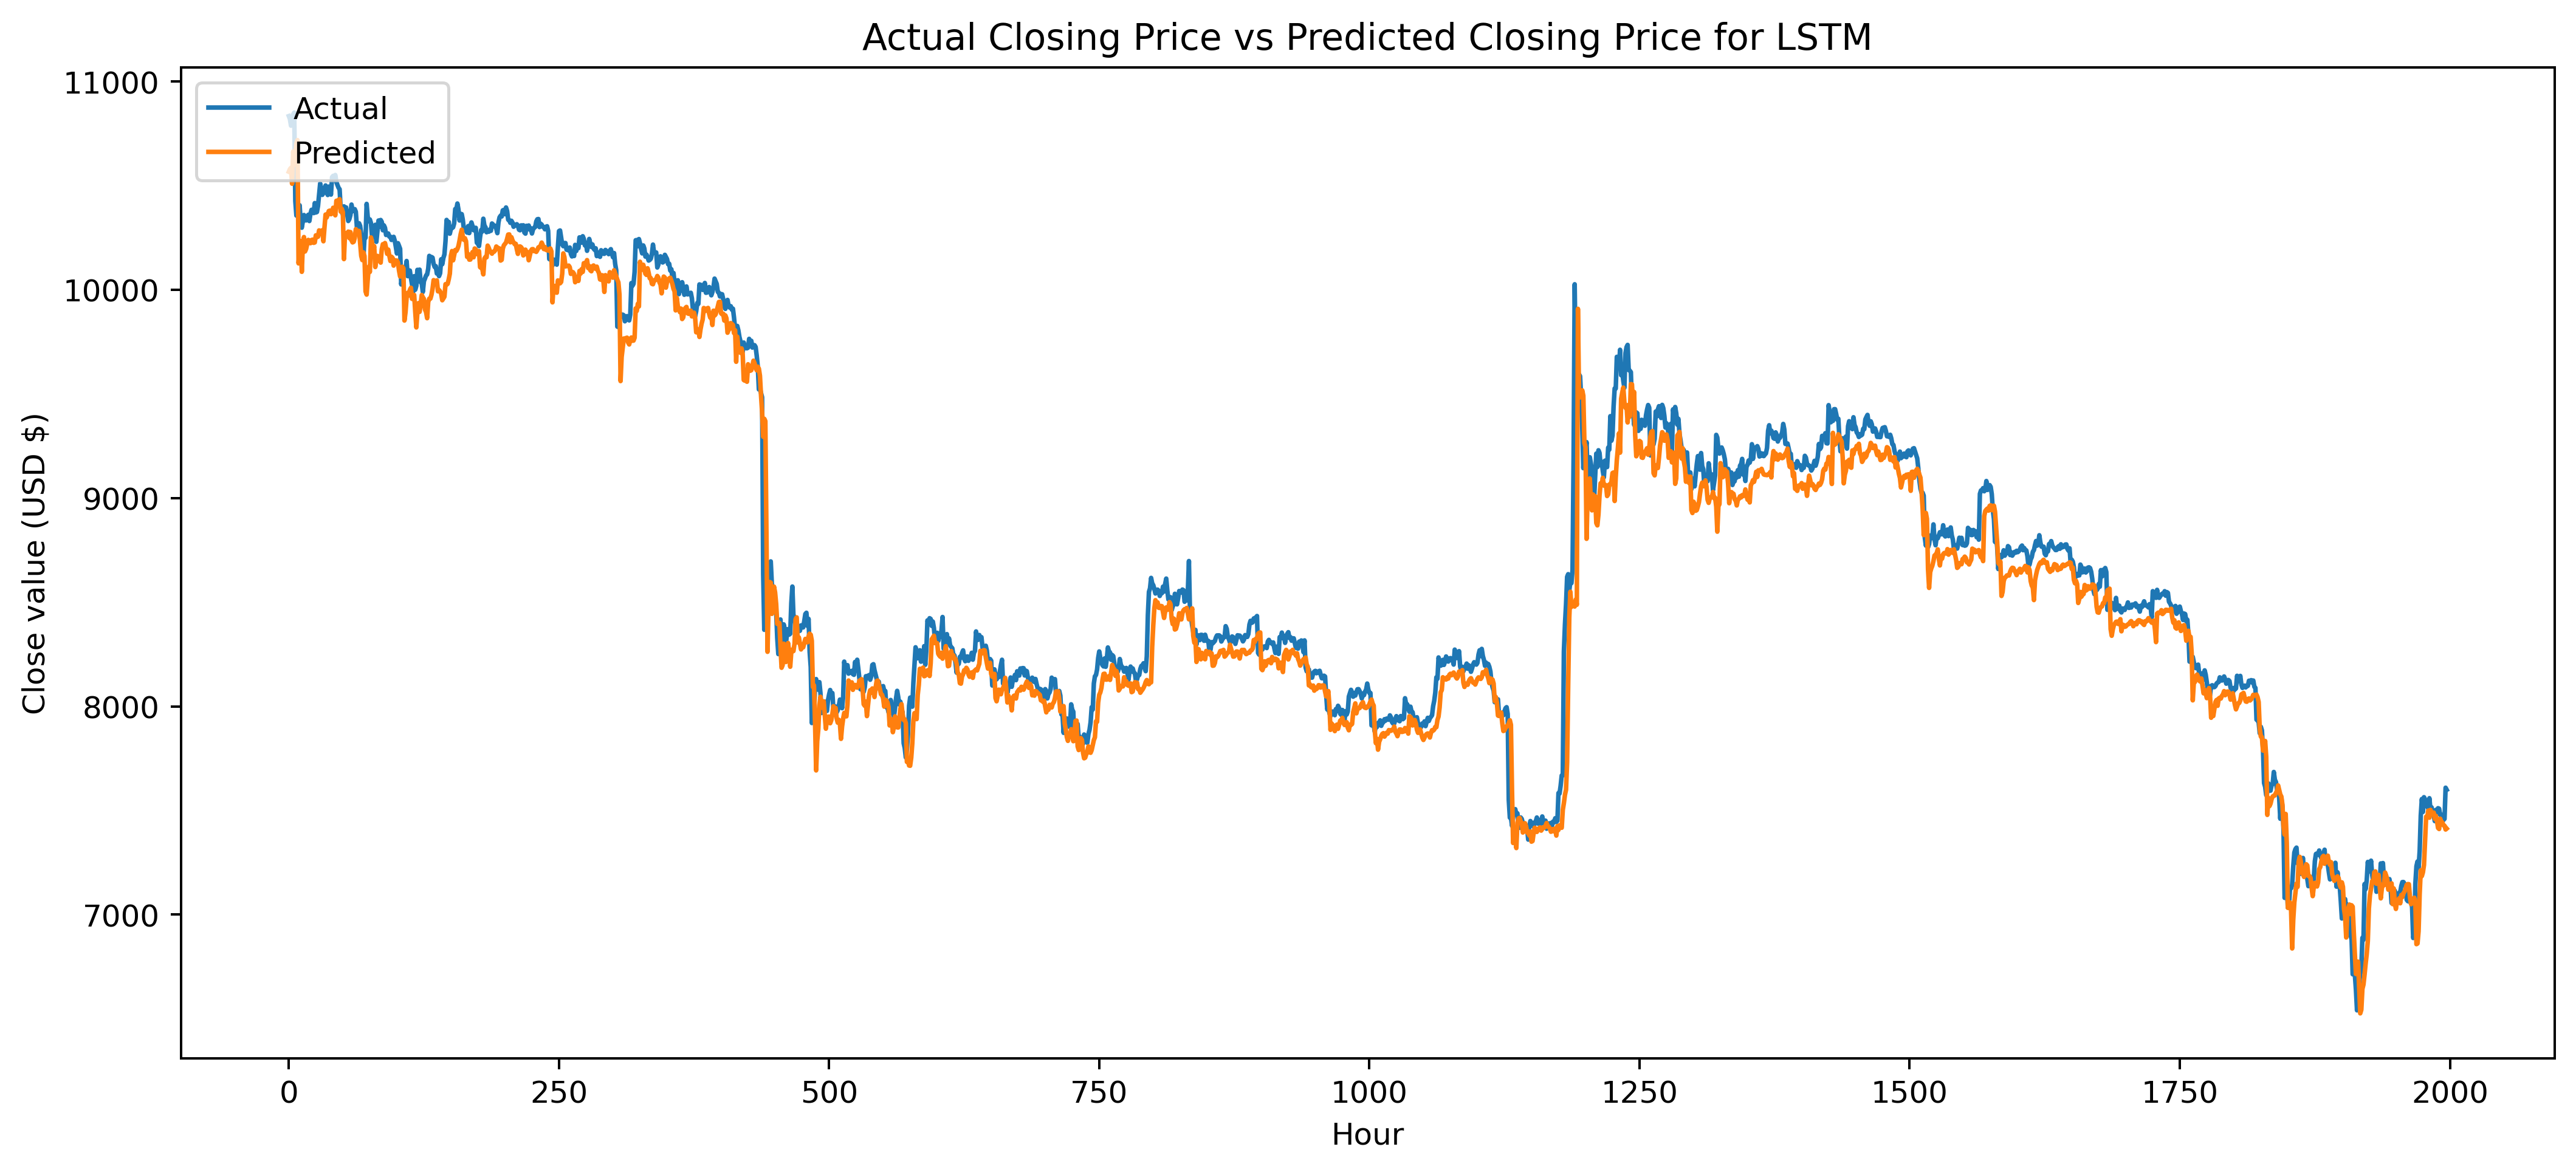

In [ ]:
plt.figure(figsize=(14, 6))
plt.rcParams['figure.dpi'] = 360
range_future_LSTM = len(prediction_LSTM)
plt.plot(np.arange(range_future_LSTM), np.array(y_test), label='Actual')
plt.plot(np.arange(range_future_LSTM), np.array(prediction_LSTM),label='Predicted')

plt.title('Actual Closing Price vs Predicted Closing Price for LSTM')
plt.legend(loc='upper left')
plt.xlabel('Hour')
plt.ylabel('Close value (USD $)')

plt.show()

**LSTM-Percent Accuracy**

This accuracy metrics is not used in evaluating regression models. It is just used here to get a sense of performance, but it will not be reported.

In [ ]:
percent_tot_LSTM=0
for i in range (len(y_test)):
  a=y_test[0]
  result_a=a[0]
  b=prediction_LSTM[0]
  result_b=b[0]

  percent= ((result_b*100)/result_a)
  if percent >100:
    percent = 100 - (percent - 100)
  percent_tot_LSTM+=percent

percent_tot_LSTM= percent_tot_LSTM/len(y_test)

print('LSTM Accuracy %: ', percent_tot_LSTM)

LSTM Accuracy %:  97.53359578332501


**LSTM-Regression Accuracy Metrics**

In order to measure the performance of the model when exposed to new data, MAE, MSE, RMSE, and MAPE are calculated for the normalized values of the predicted values and the actual values.

In [ ]:
mae_norm_LSTM = mean_absolute_error(M, C_LSTM)

mse_norm_LSTM = mean_squared_error(M, C_LSTM)

rmse_norm_LSTM = mean_squared_error(M, C_LSTM, squared=False)

mape_norm_LSTM =mean_absolute_percentage_error(M, C_LSTM)

print('LSTM MAE-Normalized: ', mae_norm_LSTM)
print ('LSTM MSE-Normalized: ', mse_norm_LSTM)
print('LSTM RMSE-Normalized: ', rmse_norm_LSTM)
print('LSTM MAPE-Normalized: ', mape_norm_LSTM)

LSTM MAE-Normalized:  0.006388780471750571
LSTM MSE-Normalized:  7.493435375960846e-05
LSTM RMSE-Normalized:  0.008656463120675122
LSTM MAPE-Normalized:  0.018337047099613733


**LSTM-Regression Accuracy Metrics Unlocked**

In the following code, MSE, RMSE, and MAE are calculated using the numpy library and using values that are not normalized. This helps in making sense of the results.

In [ ]:
errors_LSTM = prediction_LSTM - y_test
mse_LSTM = np.square(errors_LSTM).mean()
rmse_LSTM = np.sqrt(mse_LSTM)
mae_LSTM = np.abs(errors_LSTM).mean()


print('LSTM MAE: {:.4f}'.format(mae_LSTM))
print('LSTM MSE: {:.4f}'.format(mse_LSTM))
print('LSTM RMSE: {:.4f}'.format(rmse_LSTM))

LSTM MAE: 107.2708
LSTM MSE: 21125.5597
LSTM RMSE: 145.3463


**LSTM-Model Imported**

This allows us to export a model that is already saved in a JSON file and its corresnponding weights in a h5 file. The model is restored and can be used to make predictionsn visualize results, and do some data manipulation.

In [ ]:
json_file_LSTM = open ('LSTM_model_20k_batch256.json', 'r')
loaded_model_json_LSTM = json_file_LSTM.read()
json_file_LSTM.close()
loaded_model_LSTM = model_from_json(loaded_model_json_LSTM)

loaded_model_LSTM.load_weights("LSTM_model_20k_batch256.h5")
print("loaded LSTM model from disk")

prediction_again_LSTM=loaded_model_LSTM.predict(x_test)

prediction_1D_again_LSTM= prediction_again_LSTM [:, 0, 0]

C_again_LSTM=[]

for i in range (len(prediction_1D_again_LSTM)):

  D=[]
  D.append(prediction_1D_again_LSTM[i])
  C_again_LSTM.append(D)



prediction_again_LSTM=scaler_y.inverse_transform(C_again_LSTM)


prediction_again_LSTM

loaded LSTM model from disk


array([[10567.63830945],
       [10579.92452984],
       [10586.44018477],
       ...,
       [ 7427.01256675],
       [ 7408.56397092],
       [ 7413.09005179]])